This notebook contains code implementations of two Lemmas that were meant to be part of the PMP proof for tandem trajectories. "Lemma 2" gives an explicit description of trajectories, assuming initial speed $x_2(t_0) = 1)$ is maximal. "Lemma 3" considers the case when the vehicle is at rest initially $x_2(t_0) = 0$. The latter is also illustrated in an interactive figure where the position of the cursor determines the initial position (in terms of time and space).

In [1]:
import math
import pandas as pd
import numpy as np
from scipy.integrate import solve_ivp
from IPython.utils import io
import matplotlib.pyplot as plt
%cd /home/jeroen/repos/traffic-scheduling/
from motion.direct_transcription import motion_synthesize

/home/jeroen/repos/traffic-scheduling


### Setup

In [2]:
params = {
    'vmax': 1,       # maximum velocity (without loss of generality)
    'amax': 0.5,     # maximum acceleration/deceleration (symmetric bounds by assumption)
    'L': 0.75,       # follow distance = vehicle length
    'W': 0.25,       # vehicle width = lane width
    'D': 5,          # length of lane
    'dt': 0.01,      # direct transcription time-step size
}
params['p0'] = -params['D'] + params['W']     # initial position
params['l'] = params['L']                     # follow distance
params['rho'] = params['L'] / params['vmax']  # follow time

# trick: make parameters directly accessible as variables
locals().update(params)

Helper functions to integrate the control intervals into a trajectory for the direct method.

In [3]:
def interval_controller(amax, *intervals):
    def evaluate(t):
        a = 0
        for ix, i in enumerate(intervals):
            if i[0] <= t < i[1]:
                a = -amax if (ix % 2 == 0) else amax
        return a
    return evaluate

def double_integrator(control):
    return lambda t, y: (y[1], control(t))

General helper quantities and functions and helper plotting functions.

In [4]:
def acceleration(t):
    return t*t * amax / 2
def deceleration(t):
    return t - amax*t*t/2

def acc(t, v):
    return v*t + amax*t*t/2
def dec(t, v):
    return v*t - amax*t*t/2

df = vmax / amax
ds = math.sqrt(L / amax)

capacity = math.floor((D - W - 2 * acceleration(df)) / L)
pa = - 2 * acceleration(df) - (capacity - 1) * L

In [5]:
def draw_guiding_lines(intervals=None):
    # draw buffer positions
    for i in range(capacity):
        plt.axhline(y=- acceleration(df) - i * L, color='lightgrey', linestyle='--', lw=1)
    # deceleration for first waiting position
    plt.axhline(y=pa, color='lightgrey', linestyle=':', lw=1)
    # earliest deceleration position
    plt.axhline(y=p0 + L, color='lightgrey', linestyle=':', lw=1)
    # intersection v and w
    plt.axhline(y=p0 - W, color='k', linestyle='--', lw=1) # start of v
    plt.axhline(y=p0, color='k', linestyle='--', lw=1) # end of v
    plt.axhline(y=0, color='k', linestyle='--', lw=1)  # start of w

    if intervals is not None:
        for a, b in intervals:
            plt.axvline(x=a, color='lightgrey', linestyle='--', lw=1)
            plt.axvline(x=b, color='lightgrey', linestyle='--', lw=1)

### Direct transcription

In [6]:
def generate_tandem_trajectories(y, params, prev=None):
    dt = params['dt']
    trajectories = []
    for start, end in y:
        yv = int(math.ceil(start / dt))
        yw = int(math.ceil(end / dt))

        if prev is not None:
            # extract the relevant steps from prev trajectory
            prev = prev[prev['t'] >= yv * dt]['x'].to_numpy()

        with io.capture_output() as captured:
            x = motion_synthesize(yw - yv + 1, prev=prev, **params)
        xd = pd.DataFrame(x, columns=['x'])
        xd['t'] = dt * np.array(range(yv, yw + 1))
        prev = xd.copy()
        trajectories.append(xd)
    return trajectories

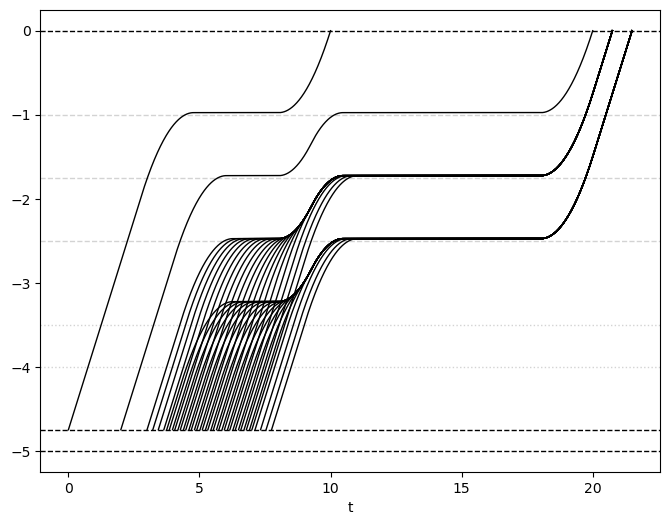

In [7]:
fig, ax = plt.subplots(figsize=(8, 6))
draw_guiding_lines()

y = [[0, 10], [2, 20]]
base = generate_tandem_trajectories(y, params)
[tr.plot(x='t', y='x', legend=False, ax=ax, lw=1, c='k') for tr in base];

for y1 in np.linspace(3, 7, num=20):
    y = [[y1, 20.75], [y1 + 0.75, 21.5]]
    trajects = generate_tandem_trajectories(y, params, prev=base[-1])
    trajects[0].plot(x='t', y='x', legend=False, ax=ax, lw=1, c='k')
    trajects[1].plot(x='t', y='x', legend=False, ax=ax, lw=1, c='k')

### Lemma 2: Optimal control for inactive safe headway constraint ($x_2(t_0) = 1$)

2.0 2.0


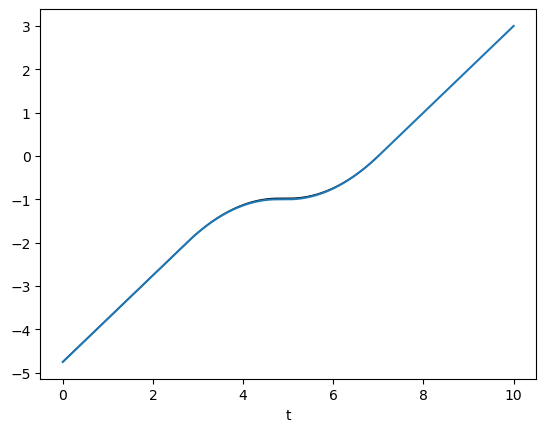

In [8]:
T = 7

y = [[0, T]]
params['dt'] = 0.01
base = generate_tandem_trajectories(y, params)
base[0].plot(x='t', y='x', legend=False, lw=1, c='k')

d = min(1 / amax, math.sqrt((p0 + T) / amax))
print(d, 1 / amax)
t_d = -p0 - 2*d + amax * d*d
t_a = T - d
intervals = [[t_d, t_d + d], [t_a, t_a + d]]

control = interval_controller(amax, *intervals)
tr = solve_ivp(double_integrator(control), [0, 10], [p0, vmax], max_step=0.01)
plt.plot(tr['t'], tr['y'][0,:])

### Lemma 3: Optimal control for inactive safe headway constraint ($x_2(t_0) = 0$)

In [9]:
def single_trajectory(start, end, v0, params):
    dt = params['dt']
    yv = int(math.ceil(start / dt))
    yw = int(math.ceil(end / dt))
    with io.capture_output() as captured:
        x = motion_synthesize(yw - yv + 1, v0=v0, **params)
    xd = pd.DataFrame(x, columns=['x'])
    xd['t'] = dt * np.array(range(yv, yw + 1))
    return xd

In [10]:
def lemma2(t0, p0):
    if t0 > p0 or t0 >= 0 or p0 >= 0:
        return None # infeasible
    d = min(1 / amax, math.sqrt((p0 - t0) / amax))
    td = -p0 - 2*d + amax * d*d
    return d, td

def lemma3(t0, p0):
    t1 = t0 + 1/amax
    p1 = p0 + 1/(2*amax)    
    res = lemma2(t1, p1)
    
    a11 = math.sqrt(-p0/amax - 1/(2*amax*amax)) if -p0/amax - 1/(2*amax*amax) >= 0 else None
    
    a12 = (p0 + 1/(2*amax))/(1+t0*amax) - (1+t0*amax)/(4*amax) if 1+t0*amax < 0 else None
    d2 = -t0/2 - 1/(2*amax)
    a22 = -a12 + 1/(2*amax) - t0/2 if a12 is not None else None

    if res is not None and t1 <= p1 and res[1] >= 0:
        td = t1 + res[1]
        a1 = 1/amax
        d = res[0]
        a2 = d

    elif a11 is not None and a11 <= 1/amax and t0 + 2*a11+1/amax < 0:
        a1 = a11
        td = t0 + a1
        d = a1
        a2 = 1/amax

    elif a12 is not None and 0 <= a12 <= 1/amax and 0 <= d2 <= 1/amax and 0 <= a22 <= 1/amax:
        a1 = a12
        td = t0 + a1
        d = d2
        a2 = a22

    else:
        return None

    return a1, td, d, a2

In [11]:
def trajectory(t0, p0, a1, td, d, a2, t):
    if t0 <= t <= t0 + a1:
        if t <= t0 + 1/amax:
            return p0 + acc(t - t0, 0)
    
    elif t0 + a1 <= t <= td:
        return p0 + acc(a1,0) + (t - a1 - t0)

    elif td <= t <= td + d:
        return p0 + acc(a1,0) + (td - a1 - t0) + dec(t - td, amax*a1)

    elif td + d <= t <= -a2:
        return p0 + acc(a1,0) + (td - a1 - t0) + dec(d, amax*a1)

    elif -a2 <= t <= 0:
        return p0 + acc(a1,0) + (td - a1 - t0) + dec(d, amax*a1) + acc(t + a2, amax*(a1 - d))

In [12]:
# 1.
t0 = -8
p0 = -4

# 2a.
t0 = -8
p0 = -2.2

# 2b.
t0 = -5.5
p0 = -3

# plot using direct transcription and by integrating intervals
# a1, td, d, a2 = lemma3(t0, p0)
# v0 = 0
# params['p0'] = p0
# params['dt'] = 0.001
# base = single_trajectory(t0, 0, v0, params)
# base.plot(x='t', y='x', legend=False, lw=1, c='k')
# intervals = [[0,0], [t0, t0 + a1], [td, td + d], [-a2, 0]]
# control = interval_controller(amax, *intervals)
# tr = solve_ivp(double_integrator(control), [t0, 0], [p0, v0], max_step=0.001)
# plt.plot(tr['t'], tr['y'][0,:])

def lemma3_plot(t0, p0):
    res = lemma3(t0, p0)
    tr = lambda t: trajectory(t0, p0, *res, t)
    ts = np.arange(t0, 0, 0.05)
    plt.plot(ts, [tr(t) for t in ts])

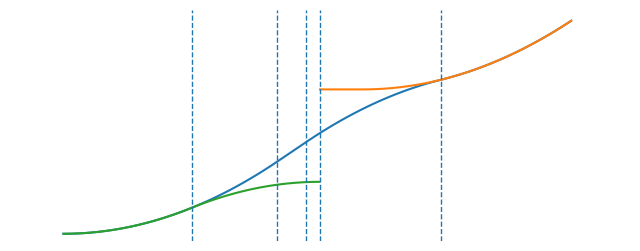

In [13]:
plt.clf()
t0, p0 = -4.8, -3
lemma3_plot(t0, p0)

# top part
eps = 0.8
lemma3_plot(-1/amax-eps/2, -1/(2*amax))
                  
# compute bottom part
a1, td, d, a2 = lemma3(t0, p0)
tr = lambda t: trajectory(t0, p0, a1-eps, t0 + a1-eps, d, a2, t)
ts = np.arange(t0, t0 + 2*(a1-eps), 0.01)
plt.plot(ts, [tr(t) for t in ts])

ax = plt.gca()
ax.axvline(x=t0 + a1-eps, linestyle='--', lw=1)
ax.axvline(x=t0 + 2*(a1-eps), linestyle='--', lw=1)
ax.axvline(x=t0 + a1, linestyle='--', lw=1)
ax.axvline(x=td, linestyle='--', lw=1)
ax.axvline(x=td + d, linestyle='--', lw=1)

ax.set_ylim([p0-0.1, 0.1])
ax.set_xlim([t0 - 0.5, 0.5])
ax.axis('off')
plt.gcf().set_size_inches(8, 3)
plt.savefig('motion/lemma3_proof1.pdf')
plt.show()

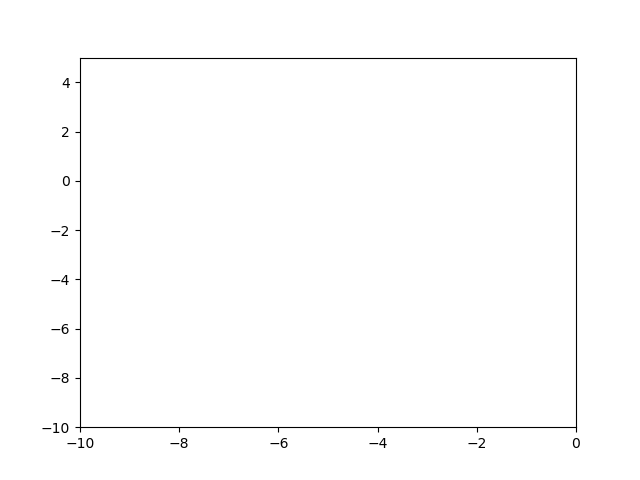

In [14]:
%matplotlib ipympl
import matplotlib.pyplot as plt
import numpy as np

from matplotlib.backend_bases import MouseButton

ax = plt.gca()
ax.set_xlim([-10, 0])
ax.set_ylim([-10, 5])

def on_move(event):
    if event.inaxes:
        print(f'data coords {event.xdata} {event.ydata},',
              f'pixel coords {event.x} {event.y}')
        plt.clf()

        t0 = event.xdata
        p0 = event.ydata
        res = lemma3(t0, p0)
        if res:
            tr = lambda t: trajectory(t0, p0, *res, t)
            ts = np.arange(t0, 0, 0.05)
            plt.plot(ts, [tr(t) for t in ts])
        
        plt.gca().set_xlim([-10, 0])
        plt.gca().set_ylim([-10, 5])
        plt.draw()


def on_click(event):
    if event.button is MouseButton.LEFT:
        print('disconnecting callback')
        plt.disconnect(binding_id)

binding_id = plt.connect('motion_notify_event', on_move)
plt.connect('button_press_event', on_click)

plt.show()

### Figures for report

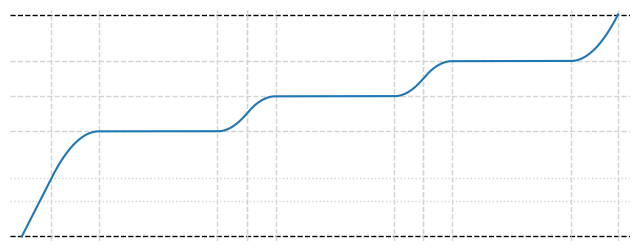

In [8]:
intervals = []

t_d = (pa - p0) / vmax
sn = [t_d + df + 5, t_d + df + 5 + 2 * ds + 5]
t_a = t_d + df + 5 + 2*ds + 5 + 2*ds + 5

# add initial deceleration interval
intervals.append([t_d, t_d + df])

# add start-stop intervals
for ts in sn:
    S = [[ts, ts+ds], [ts+ds, ts+2*ds]]
    intervals.extend(S)

# add final acceleration interval
intervals.append([t_a, t_a + df])

control = interval_controller(amax, *intervals)
tr = solve_ivp(double_integrator(control), [0, t_a + df], [p0, vmax], max_step=0.001)
draw_guiding_lines(intervals)
plt.plot(tr.t, tr.y[0,:]);
ax = plt.gca()
ax.set_ylim([p0-0.1, 0.1])
ax.set_xlim([0 - 0.5, t_a + df + 0.5])
ax.axis('off')
plt.gcf().set_size_inches(8, 3)
plt.savefig('motion/tandem_trajectory.pdf')

### Experiments

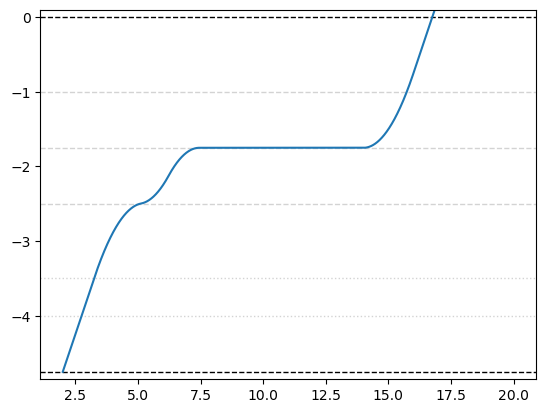

In [9]:
add = 2
t_d = (pa - p0) / vmax + add
s_1 = 5
t_a = 14

if t_d + df <= s_1:
    # separate
    intervals = [[t_d, t_d + df], [s_1, s_1 + ds], [s_1 + ds, s_1 + 2*ds]]
elif t_d >= s_1 + 2 * ds - df - 2 * acceleration(ds) / vmax:
    # merged
    intervals = [[s_1 + 2 * ds - df, s_1 + 2 * ds]]
else:
    # merging
    eps = (df - math.sqrt(df * (s_1 - t_d)))
    intervals = [[s_1 + 2 * eps - df, s_1 + eps],
                 [s_1 + eps, s_1 + ds],
                 [s_1 + ds, s_1 + 2 * ds]]

# final acceleration
intervals.append([t_a, t_a + df])

control = interval_controller(amax, *intervals)
tr = solve_ivp(double_integrator(control), [add, 20], [p0, vmax], max_step=0.001)
draw_guiding_lines()
plt.plot(tr.t, tr.y[0,:]);
plt.gca().set_ylim([p0 - 0.1, 0 + 0.1]);

0.3252551286084109
0.2747448713915892
0.75


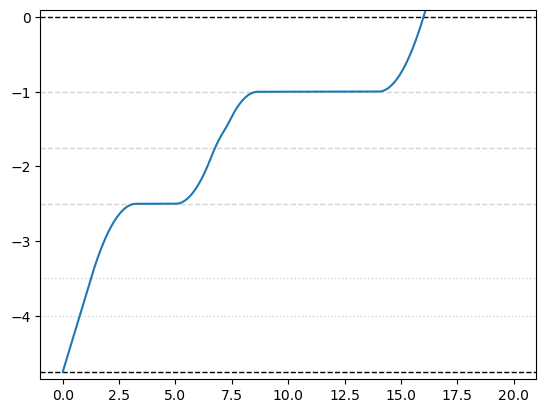

In [10]:
intervals = []

t_d = (pa - p0) / vmax
t_1 = 5
t_2 = 6.2
t_a = 14

# initial deceleration
intervals.append([t_d, t_d + df])

delta = L/amax / (t_2 - t_1) - ds + (t_2 - t_1) / 4
eps = (t_2 - t_1)/2 - delta

print(delta)
print(eps)
print(2 * acceleration(ds + delta) - 2 * acceleration(ds - eps))

intervals.extend([[t_1, t_1 + ds + delta],
                  [t_1 + ds + delta, t_1 + ds + delta + (delta + eps)],
                  [t_2 + ds - eps, t_2 + ds],
                  [t_2 + ds, t_2 + 2*ds]])

# final acceleration
intervals.append([t_a, t_a + df])

control = interval_controller(amax, *intervals)
tr = solve_ivp(double_integrator(control), [0, 20], [p0, vmax], max_step=0.001)
draw_guiding_lines()
plt.plot(tr.t, tr.y[0,:]);
plt.gca().set_ylim([p0 - 0.1, 0 + 0.1]);